# Finding and Visualizing Paths from KRAS to Survival Rate using System API

This notebook demonstrates how to use the System API to find paths between KRAS and survival rate, and then visualize these paths using NetworkX and Matplotlib.

## Setup Notebook

### Import libraries and define helper functions

In [1]:
!pip install api-client==1.51.0 --extra-index-url https://pypi.fury.io/systeminc/
!pip install networkx
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.fury.io/systeminc/

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import os

# Ensure the output is displayed inline in the notebook
%matplotlib inline

## Setting up the API Client

First, we need to set up the API client with your API key.

In [10]:
%env YOUR_API_KEY=<YOUR_API_KEY>

env: YOUR_API_KEY=<YOUR_API_KEY>


In [4]:
from api_client import ApiClient, GraphApi, Configuration

# Replace 'YOUR_API_KEY' with your actual API key
API_KEY = os.environ.get("YOUR_API_KEY")
if not API_KEY:
	raise ValueError("API key is missing")

api_client = ApiClient(configuration=Configuration(server_index=2),header_name="x-api-key", header_value=API_KEY)
graph_api = GraphApi(api_client)

## Querying the System Graph

Now, let's define a function to query the System Graph for paths between KRAS and survival rate.

In [5]:
def find_directional_paths(start_topic_search, end_topic_search, max_hops=3):
    cypher_query = f"""
    MATCH (start:Topic)
    WHERE toLower(start.label) CONTAINS toLower("{start_topic_search}")
    MATCH (end:Topic)
    WHERE toLower(end.label) CONTAINS toLower("{end_topic_search}")
    MATCH path = (start)-[:RELATES_TO*1..{max_hops}]->(end)
    RETURN path, start.label AS start_name, end.label AS end_name
    LIMIT 10
    """

    payload = {
        "query": cypher_query,
        "params": {}
    }

    try:
        response = graph_api.post_cypher_query(cypher_payload=payload)
        return response
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

## Querying for Paths

Let's use our function to find paths between KRAS and survival rate.

In [6]:
start_topic_search = "KRAS"
end_topic_search = "survival rate"
max_hops = 3

response = find_directional_paths(start_topic_search, end_topic_search, max_hops)
records = response.records
if not records:
    print("No data returned from the query.")
else:
    print(f"Query returned {len(records)} results.")

Query returned 10 results.


## Processing the Response

Now, let's process the response and create a NetworkX graph.

In [7]:
G = nx.DiGraph()

for record in records:
    path = record['path']
    for i in range(0, len(path), 2):  # Skip the 'RELATES_TO' strings
            node = path[i]
            G.add_node(node['label'], category=node['category'])
            if i + 2 < len(path):
                next_node = path[i+2]
                G.add_edge(node['label'], next_node['label'])
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph created with 15 nodes and 22 edges.


## Visualizing the Graph

Finally, let's visualize our graph.

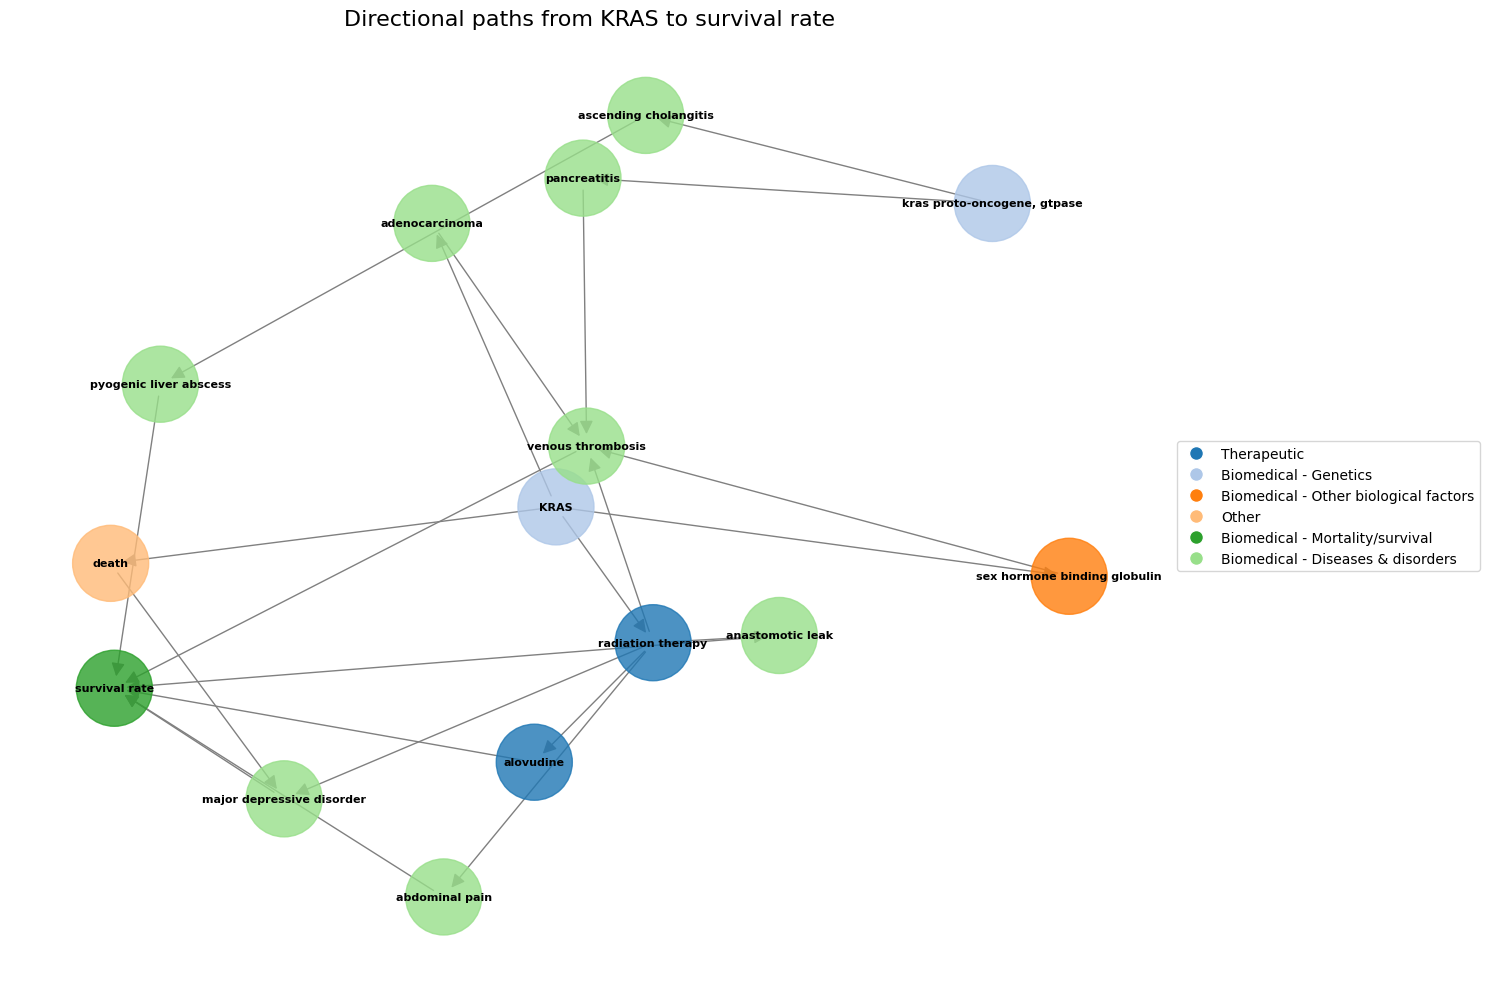

In [8]:
plt.figure(figsize=(15, 10))

pos = nx.spring_layout(G, k=0.9, iterations=50)

unique_categories = set(nx.get_node_attributes(G, 'category').values())
color_map = dict(zip(unique_categories, plt.cm.tab20.colors[:len(unique_categories)]))

node_colors = [color_map[G.nodes[node]['category']] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=node_colors, alpha=0.8)

nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)

nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

plt.title(f"Directional paths from {start_topic_search} to {end_topic_search}", fontsize=16)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category,
                              markerfacecolor=color, markersize=10)
                   for category, color in color_map.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('off')
plt.tight_layout()
plt.show()

## Printing Paths

Let's also print out the paths we found.

In [9]:
for i, record in enumerate(records, 1):
    path = record['path']
    path_info = []
    for node in path[::2]:  # Skip 'RELATES_TO'
        path_info.append(f"{node['label']} ({node['category']})")

    print(f"Path {i}: " + " -> ".join(path_info))


Path 1: KRAS (Biomedical - Genetics) -> radiation therapy (Therapeutic) -> major depressive disorder (Biomedical - Diseases & disorders) -> survival rate (Biomedical - Mortality/survival)
Path 2: KRAS (Biomedical - Genetics) -> death (Other) -> major depressive disorder (Biomedical - Diseases & disorders) -> survival rate (Biomedical - Mortality/survival)
Path 3: KRAS (Biomedical - Genetics) -> radiation therapy (Therapeutic) -> anastomotic leak (Biomedical - Diseases & disorders) -> survival rate (Biomedical - Mortality/survival)
Path 4: KRAS (Biomedical - Genetics) -> sex hormone binding globulin (Biomedical - Other biological factors) -> venous thrombosis (Biomedical - Diseases & disorders) -> survival rate (Biomedical - Mortality/survival)
Path 5: KRAS (Biomedical - Genetics) -> radiation therapy (Therapeutic) -> venous thrombosis (Biomedical - Diseases & disorders) -> survival rate (Biomedical - Mortality/survival)
Path 6: kras proto-oncogene, gtpase (Biomedical - Genetics) -> pan